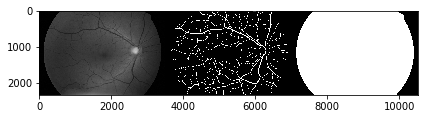

In [1]:
import skimage.io
import skimage.color
import os
import numpy as np
from skimage.util import img_as_float

def loadImageNr(id,show=False):
    
    img_list=os.listdir("./all/images")
    if(id>=len(img_list)):
        print("> bad img num, max: "+str(len(img_list)-1))
        return
    exp_list=os.listdir("./all/manual1")
    fov_list=os.listdir("./all/mask")
    img=img_as_float(skimage.io.imread("./all/images/"+str(img_list[id])))
    exp=img_as_float(skimage.io.imread("./all/manual1/"+str(exp_list[id])))
    fov=skimage.io.imread("./all/mask/"+str(fov_list[id]),as_gray=True)
    img=img[:, :, 1]
    if(show): 
        skimage.io.imshow(np.hstack([img,exp,fov]))
        skimage.io.show()
    return (img,exp,fov)

(img,exp,fov)=loadImageNr(44,show=True)


In [21]:
sharpen = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
from scipy.signal import convolve2d

def multi_convolver(image, kernel, iterations):
    for i in range(iterations):
        image = convolve2d(image, kernel, 'same', boundary = 'fill',
                           fillvalue = 0)
    return image
#img=skimage.util.invert(img)
img=multi_convolver(img, sharpen, 1)
#skimage.io.imshow(multi_convolver(img, sharpen, 1),cmap='gray')
#print(img)

preparing data...
learning (fitting)...
predicting...


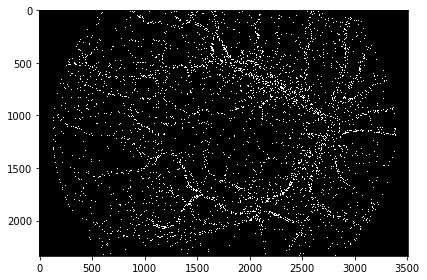

In [5]:
# import the necessary packages
import imutils
import cv2
import time
import statistics
from scipy.stats import moment
from sklearn.neighbors import KNeighborsClassifier

# src: https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/
def sliding_window(image,fov, stepSize, windowSize):
    dim=image.shape
    dim_x=dim[1]
    dim_y=dim[0]
    for y in range(0, dim_y, stepSize):
        if y + windowSize >= dim_y: # bottom border - discard
            continue 
            
        for x in range(0, dim_x, stepSize):
            if x + windowSize >= dim_x: # right border - discard
                continue 
            if fov[y,x] and fov[y+windowSize,x+windowSize] and fov[y,x+windowSize] and fov[y+windowSize,x]:
                #all corners inside FOV
                yield (x, y, image[y:y + windowSize, x:x + windowSize])
                
def sliding_window2(image,fov, stepSize, windowSize):
    dim=image.shape
    dim_x=dim[1]
    dim_y=dim[0]
    for y in range(0, dim_y, stepSize):
        if y + windowSize >= dim_y: # bottom border - discard
            continue 
            
        for x in range(0, dim_x, stepSize):
            if x + windowSize >= dim_x: # right border - discard
                continue 
            if fov[y,x] and fov[y+windowSize,x+windowSize] and fov[y,x+windowSize] and fov[y+windowSize,x]:
                #all corners inside FOV
                yield (x, y, image[y:y + windowSize, x:x + windowSize])

                
windowSize=5
stepSize=5
visualize=False
#learning
print("preparing data...")
correct_answers=[]
inputs=[]

for (x, y, window) in sliding_window(img, fov, stepSize, windowSize):
    correct_answer = exp[y+windowSize//2,x+windowSize//2]>0.5
    flat_window=window.flatten()
    pvar=statistics.pvariance(flat_window)
    mom2=moment(flat_window,2)
    correct_answers.append(correct_answer)
    inputs.append([pvar,mom2])
    
    if(visualize):
        whole_img = img.copy()
        cv2.rectangle(whole_img, (x, y), (x + windowSize, y + windowSize), (255, 255, 0), 2)
        cv2.imshow("Whole_img", imutils.resize(whole_img,width=900))

        window[2,2]=correct_answer
        cv2.imshow("Window", imutils.resize(window,width=300))
        print(pvar,correct_answer, mom2)
        cv2.waitKey(1000)
#learning 
print("learning (fitting)...")
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(inputs, correct_answers)

#predicting
print("predicting...")
predicted_image=np.zeros(fov.shape)
for (x, y, window) in sliding_window2(img, fov, 1, windowSize):
    
    
    
    flat_window=window.flatten()
    pvar=statistics.pvariance(flat_window)
    mom2=moment(flat_window,2)
    
    answer=neigh.predict([[pvar,mom2]])
    predicted_image[y+windowSize//2,x+windowSize//2]=answer
skimage.io.imshow(predicted_image,cmap='gray')
cv2.imshow("XD",imutils.resize(predicted_image,width=900))